In [76]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (8, 8)

In [77]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Notes and open questions

* Sensitivity of the classifier (complexity, n_samples, etc)? Assumptions on the shape of s(x)? 
* Best way to approximate p(s(x)|theta)? Histograms or KDE? Sensitivity of n_samples?

# Approximating distribution from histogram and KDE

In [78]:
class histogram_rv(object):
    def __init__(self, samples, n_bins=20):
        self.samples = samples
        self.n_bins = n_bins
        
        self.hist, self.bins = np.histogram(samples, bins=n_bins, density=True)       
        self.hist = np.hstack(([0.], self.hist, [0.]))
        
        self.dx = self.bins[1] - self.bins[0]
        s = 0.5 * (self.bins.max() - self.bins.min()) / (n_bins - 1) 
        self.bins = np.hstack(([-np.inf], self.bins, [np.inf]))
        self.bins[1] -= s
        self.bins[-2] += 1
        
    def pdf(self, x):
        return self.hist[np.searchsorted(self.bins, x) - 1]
    
    def cdf(self, x):
        return np.cumsum(self.hist)[np.searchsorted(self.bins, x) - 1] * self.dx

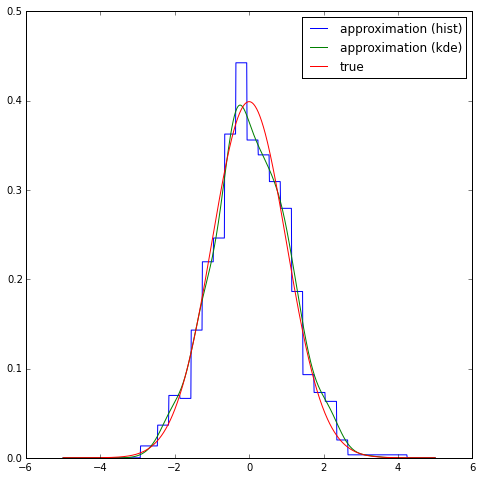

In [79]:
from scipy.stats import norm
from scipy.stats import gaussian_kde

d = np.random.normal(size=1000)
histogram = histogram_rv(d)
kde = gaussian_kde(d)

x = np.linspace(-5, 5, num=1000)

plt.plot(x, histogram.pdf(x), "b", label="approximation (hist)")
plt.plot(x, kde.pdf(x), "g", label="approximation (kde)")
plt.plot(x, norm.pdf(x), "r", label="true")
plt.ylim(0.0, 0.5)
plt.legend(loc="best")
plt.show()

# Approximating likelihood ratios

In [80]:
class composed_rv(object):
    def __init__(self, components, weights):
        self.components = components
        self.weights = weights
        
    def pdf(self, x):
        return sum(p_c.pdf(x) * w for p_c, w in zip(self.components, self.weights))
    
    def rvs(self, n_samples=1):
        _, c = np.where(np.random.multinomial(1, self.weights, n_samples) == 1)
        samples = []

        for i in range(n_samples):
            samples.append(self.components[c[i]].rvs())

        return np.array(samples)

In [81]:
# Define distributions
components = [norm(loc=-2.0, scale=0.75), 
              norm(loc=0.0, scale=2.0), 
              norm(loc=1.0, scale=0.75)]
w_0 = [0.5, 0.5, 0.025] 
w_1 = [0.5, 0.5, 0.0] 

w_0 = np.array(w_0)
w_0 /= w_0.sum()
w_1 = np.array(w_1)
w_1 /= w_1.sum()
    
p_theta_0 = composed_rv(components, w_0)
p_theta_1 = composed_rv(components, w_1)

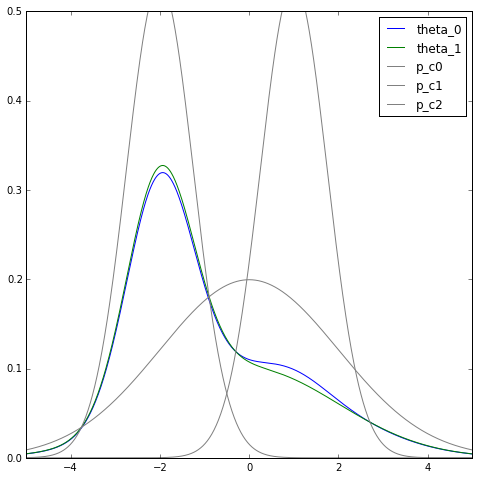

In [82]:
# Plot
x = np.linspace(-5, 5, num=1000)
plt.plot(x, p_theta_0.pdf(x), label="theta_0")
plt.plot(x, p_theta_1.pdf(x), label="theta_1")

for i, p_c in enumerate(components):
    plt.plot(x, p_c.pdf(x), "gray", label="p_c%d" % i)

plt.xlim(-5, 5)
plt.ylim(0, 0.5)
plt.legend()
plt.show()

## Using full distributions

In [83]:
def likelihood_ratio(d, p_theta_0, p_theta_1, log=True):
    with np.warnings.catch_warnings():
        np.warnings.simplefilter("ignore")
        
        if log:
            r = np.log(p_theta_0.pdf(d)) - np.log(p_theta_1.pdf(d))
        else:
            r = p_theta_0.pdf(d) / p_theta_1.pdf(d)
        
    r[np.isnan(r)] = 1
    r[np.isinf(r)] = 1   
    
    return r

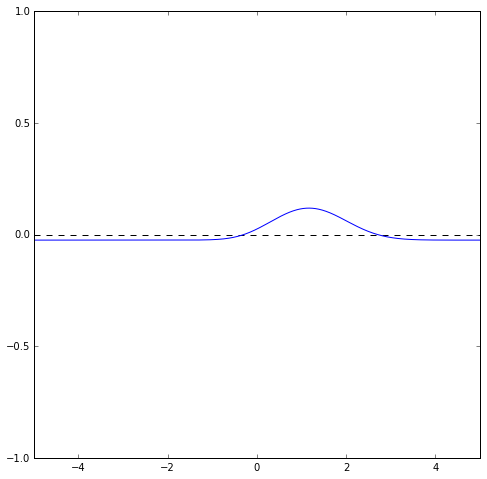

In [84]:
x = np.linspace(-5, 5, num=1000)
plt.plot([-5, 5], [0.0, 0.0], "k--")
plt.plot(x, likelihood_ratio(x, p_theta_0, p_theta_1))
plt.xlim(-5, 5)
plt.ylim(-1, 1)
plt.show()

In [88]:
# Build a classification task between the two full distributions
n_samples = 1000
d_0 = p_theta_0.rvs(n_samples).reshape((-1, 1))
d_1 = p_theta_1.rvs(n_samples).reshape((-1, 1))
X = np.vstack((d_0, d_1))
y = np.ones(len(X))
y[:n_samples] = 0

# Build a classifier
from sklearn.linear_model import ElasticNetCV
clf = ElasticNetCV()
clf.fit(X, y)

# Fit score distributions on new data
n_samples = 100000  # Goodness of fit is sensitive to that
d_0 = p_theta_0.rvs(n_samples).reshape((-1, 1))
d_1 = p_theta_1.rvs(n_samples).reshape((-1, 1))

# Approximate the full score distributions using KDE
p_s_theta_0 = gaussian_kde(clf.decision_function(d_0))
p_s_theta_1 = gaussian_kde(clf.decision_function(d_1))

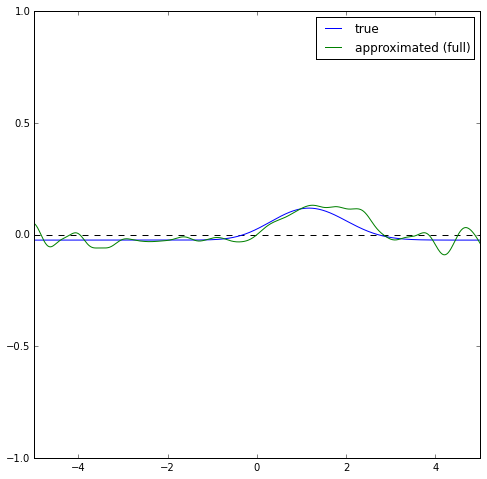

In [89]:
x = np.linspace(-5, 5, num=1000)
plt.plot([-5, 5], [0.0, 0.0], "k--")
plt.plot(x, likelihood_ratio(x, p_theta_0, p_theta_1), label="true")
plt.plot(x, likelihood_ratio(clf.decision_function(x.reshape(-1, 1)), p_s_theta_0, p_s_theta_1), label="approximated (full)")
plt.xlim(-5, 5)
plt.ylim(-1, 1)
plt.legend()
plt.show()

In [90]:
def likelihood_ratio_statistic(d, p_theta_0, p_theta_1, log=True):
    r = likelihood_ratio(d, p_theta_0, p_theta_1, log=log)
    
    if log:
        return np.sum(r)
    else:
        return np.prod(r[r != 0])

n_samples = 1000
print(likelihood_ratio_statistic(d_0[:n_samples], p_theta_0, p_theta_1))
print(likelihood_ratio_statistic(d_1[:n_samples], p_theta_0, p_theta_1))
print(likelihood_ratio_statistic(clf.decision_function(d_0[:n_samples].reshape(-1, 1)), p_s_theta_0, p_s_theta_1))
print(likelihood_ratio_statistic(clf.decision_function(d_1[:n_samples].reshape(-1, 1)), p_s_theta_0, p_s_theta_1))

# Not sure if differences are due to numerical issues, imprecision of the classifiers, or other things
# But at least, orders of magnitude are OK

2.65819501626
-0.828580233607
4.34066978174
-0.813748694373


## Using decomposed distributions

In [91]:
def likelihood_ratio_decomposed(d, p_c_theta_0, p_c_theta_1, w_0, w_1, log=True):
    r = np.zeros(len(d))
    
    for p_c_i_theta_0, w_i_0 in zip(p_c_theta_0, w_0):
        s = np.zeros(len(d))
        
        for p_c_j_theta_1, w_j_1 in zip(p_c_theta_1, w_1):
            s += w_j_1 * p_c_j_theta_1.pdf(d)
            
        r += w_i_0 * p_c_i_theta_0.pdf(d) / s
        
    r[np.isnan(r)] = 1
    r[np.isinf(r)] = 1
        
    if log:
        return np.log(r)
    
    else:
        return r

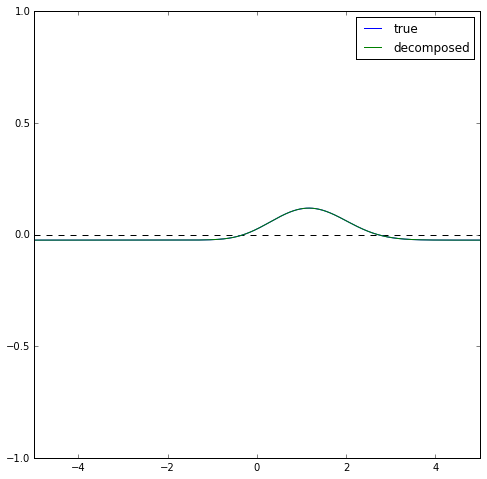

In [92]:
x = np.linspace(-5, 5, num=1000)
plt.plot([-5, 5], [0.0, 0.0], "k--")
plt.plot(x, likelihood_ratio(x, p_theta_0, p_theta_1), label="true")
plt.plot(x, likelihood_ratio_decomposed(x, components, components, w_0, w_1), label="decomposed")
plt.xlim(-5, 5)
plt.ylim(-1, 1)
plt.legend()
plt.show()

In [93]:
from sklearn.linear_model import ElasticNetCV

def fit_classifiers(components):
    classifiers = {}
    distributions = {}

    for i, p_c_i in enumerate(components):
        for j, p_c_j in enumerate(components): 
            print("Fitting %d, %d" % (i, j))

            # Skip
            if i == j:
                continue

            # Build a classification task between the two components
            n_samples = 1000
            d_i = p_c_i.rvs(n_samples).reshape(-1, 1) 
            d_j = p_c_j.rvs(n_samples).reshape(-1, 1) 
            X = np.vstack((d_i, d_j))
            y = np.ones(len(X))
            y[:n_samples] = 0

            # Build a classifier
            clf_ij = ElasticNetCV()
            clf_ij.fit(X, y)
            classifiers[(i, j)] = clf_ij

            # Fit score distributions on new data
            n_samples = 100000  # Goodness of fit is sensitive to that
            d_i = p_c_i.rvs(n_samples).reshape(-1, 1) 
            d_j = p_c_j.rvs(n_samples).reshape(-1, 1) 

            # Approximate the pair score distributions using KDE
            p_s_ci_cj_theta_0 = gaussian_kde(clf_ij.decision_function(d_i))
            p_s_ci_cj_theta_1 = gaussian_kde(clf_ij.decision_function(d_j))

            distributions[(i, j, 0)] = p_s_ci_cj_theta_0
            distributions[(i, j, 1)] = p_s_ci_cj_theta_1
            
    return classifiers, distributions

classifiers, distributions = fit_classifiers(components)

Fitting 0, 0
Fitting 0, 1
Fitting 0, 2
Fitting 1, 0
Fitting 1, 1
Fitting 1, 2
Fitting 2, 0
Fitting 2, 1
Fitting 2, 2


In [94]:
def approximate_likelihood_ratio_decomposed(d, classifiers, distributions, w_0, w_1, log=True):
    # Assume components are the same, only weights are different
    r = np.zeros(len(d))
    
    for i, w_i_0 in enumerate(w_0):
        s = np.zeros(len(d))
        
        for j, w_j_1 in enumerate(w_1):
            if i == j:
                s += (w_j_1 / w_i_0) * np.ones(len(d))
                
            else:
                clf = classifiers[(i, j)]
                p_s_ci_cj_theta_0 = distributions[(i, j, 0)]
                p_s_ci_cj_theta_1 = distributions[(i, j, 1)]
                
                s += (w_j_1) / (w_i_0) * (p_s_ci_cj_theta_1.pdf(clf.decision_function(d)) / 
                                          p_s_ci_cj_theta_0.pdf(clf.decision_function(d)))
                
        r += 1.0 / s
        
    r[np.isnan(r)] = 1
    r[np.isinf(r)] = 1
        
    if log:
        return np.log(r)
    
    else:
        return r

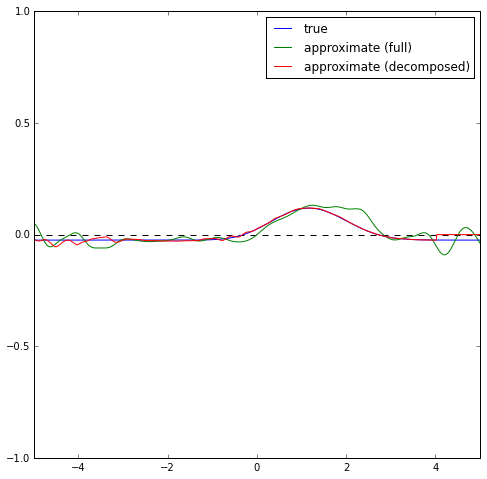

In [95]:
x = np.linspace(-5, 5, num=1000)
plt.plot([-5, 5], [0.0, 0.0], "k--")
plt.plot(x, likelihood_ratio(x, p_theta_0, p_theta_1), label="true")
plt.plot(x, likelihood_ratio(clf.decision_function(x.reshape(-1, 1)), p_s_theta_0, p_s_theta_1), label="approximate (full)")
plt.plot(x, approximate_likelihood_ratio_decomposed(x.reshape(-1, 1), classifiers, distributions, w_0, w_1), label="approximate (decomposed)")
plt.xlim(-5, 5)
plt.ylim(-1, 1)
plt.legend()
plt.show()

# Finding composition weights

In [100]:
components = [norm(loc=-2.0, scale=0.75), 
              norm(loc=0.0, scale=2.0), 
              norm(loc=1.0, scale=0.75)]
w_0 = [0.5, 0.5, 0.1] 
w_1 = [0.5, 0.5, 0.0] 

w_0 = np.array(w_0)
w_0 /= w_0.sum()
w_1 = np.array(w_1)
w_1 /= w_1.sum()
    
p_theta_0 = composed_rv(components, w_0)
p_theta_1 = composed_rv(components, w_1)

In [101]:
test = p_theta_0.rvs(1000).reshape(-1, 1)
classifiers, distributions = fit_classifiers(components)

for w_0_2 in np.linspace(0, 0.5, num=10+1):
    w_0b = w_0[:]
    w_0b[2] = w_0_2
    w_0b /= w_0b.sum()
    
    t = approximate_likelihood_ratio_decomposed(test, classifiers, distributions, w_0b, w_1).sum()
    print(w_0_2, t)

Fitting 0, 0
Fitting 0, 1
Fitting 0, 2
Fitting 1, 0
Fitting 1, 1
Fitting 1, 2
Fitting 2, 0
Fitting 2, 1
Fitting 2, 2
0.0 0.0
0.05 9.66595886567
0.1 11.9011305423
0.15 8.14573031981
0.2 -0.672950518934
0.25 -13.9929022766
0.3 -31.4803408539
0.35 -52.9568689937
0.4 -78.358527112
0.45 -107.712093487
0.5 -141.121377306
